In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import warnings
import nltk 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score,recall_score, accuracy_score, make_scorer, f1_score
from sklearn.model_selection import cross_val_score,train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from pandarallel import pandarallel
from os import walk
from wordcloud import WordCloud, STOPWORDS
from time import time


# pandarallel to improve execution performance
# pandarallel.initialize(progress_bar=True)


# disable unuseful warnings
def warn(*args, **kwargs):
    pass

warnings.warn = warn

# Phishing Detection

### Import lib

### Import URL dataset

In [2]:
# Read the url database
urls_df = pd.read_csv(r'phishing_site_urls.csv')

# Rename the column from "URL" to "Content"
urls_df.rename(columns = {'URL':'Content'}, inplace = True)

# Change label "bad" in 0 and "good" in 1
urls_df.loc[urls_df["Label"]=="bad", "Label"]= 0
urls_df.loc[urls_df["Label"]=="good", "Label"]= 1
urls_df.sample(5)


,Content,Label
84615,www.lbl.gov/ITSD/Security/systems/apache-serve...,1
355693,huffingtonpost.com/books/,1
538366,dedivan.ru/cart.php?shopping_cart=yes&add2cart=64,0
28414,getir.net/ck1j,0
199159,icehockey.wikia.com/wiki/2008-09_NHL_season,1


In [3]:
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  549346 non-null  object
 1   Label    549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [4]:
urls_df.drop_duplicates(inplace=True)
urls_df.isnull().sum()

Content    0
Label      0
dtype: int64

In [5]:
label_counter = pd.DataFrame(urls_df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

1    392897
0    114299
Name: Label, dtype: int64


,Content,Label
3984,Subject: update on timing of forms\n i am tryi...,1
6839,Subject: delegation of authority\n louise :\n ...,1
26308,Subject: re [ 18 ] :\n in 1946 to draw your at...,0
10577,Subject: rodrigo lamas - best wishes\n i would...,1
26442,Subject: urgent\n simply the best meds on the ...,0
13025,"Subject: ipps in ercot\n jim ,\n can we meet o...",1
24439,Subject: your friends will envy you\n my girlf...,0
15483,"Subject: re : bullet points\n hi vince ,\n tha...",1
25831,Subject: highly recommended ciialis ba 6 dc\n ...,0
16632,Subject: enjoy media ( ejym ) enters chinese t...,0


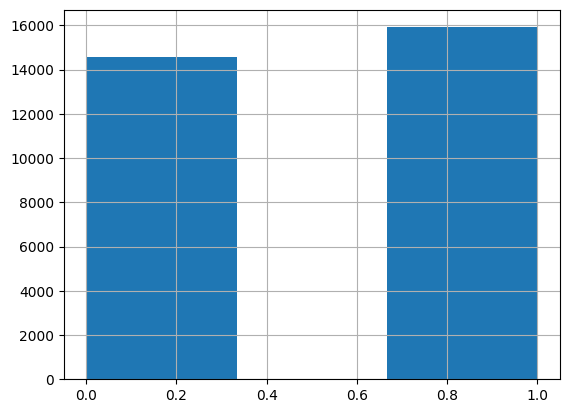

In [6]:
# Read the emails dataset
pathwalk = walk(r"enron-spam/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))
                
# remove all redundant data
allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))

# merge it in a dataframe
hamPlusSpamData = allHamData + allSpamData

# Labels: "bad" = 0 and "good" = 1
labels = [1]*len(allHamData) + [0]*len(allSpamData)

emails_df = pd.DataFrame({"Content": hamPlusSpamData, "Label": labels})

# get an overview of the data
emails_df.Label.hist(bins=3)
emails_df.sample(10)

### Merge urls dataframe with emails dataframe 

In [7]:
df = pd.concat([urls_df, emails_df], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537690 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  537690 non-null  object
 1   Label    537690 non-null  object
dtypes: object(2)
memory usage: 12.3+ MB


In [8]:
label_counter = pd.DataFrame(df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.show()

1    408807
0    128883
Name: Label, dtype: int64


## Preprocessing

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
snow_stemmer = SnowballStemmer('english')

#### Use RegexpTokenizer

In [10]:
# try if it works
'''
analyzer = RegexpTokenizer(stop_words = stopwords).build_analyzer()
analyzer(df.Content.values[3])
'''

'\nanalyzer = RegexpTokenizer(stop_words = stopwords).build_analyzer()\nanalyzer(df.Content.values[3])\n'

#### Use TfidfVectorizer

In [11]:
analyzer = CountVectorizer(stop_words = stopwords).build_analyzer()
# analyzer(df.Content.values[8])

In [12]:

# analyzer = TfidfVectorizer(stop_words = stopwords).build_analyzer()
# analyzer(df.Content.values[3])

def snowball_analyzer(doc):
    return [snow_stemmer.stem(w) for w in analyzer(doc)]

# snowball_analyzer(df.Content.values[8]) 

In [13]:
# df['text_tokenized'] = df.Content.parallel_map(lambda t: analyzer(t))
# df['text_stemmed'] = df['text_tokenized'].parallel_map(lambda l: [snow_stemmer.stem(word) for word in l])
# df['text_sent'] = df['text_stemmed'].parallel_map(lambda l: ' '.join(l))

In [14]:
#for i in range(len(df)):
#    snowball_analyzer(df['text_sent'].values[i])

In [15]:
'''
def print_metrics(results):
    metrics = ['accuracy','precision_ham', 'recall_ham','precision_spam', 'recall_spam']
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])
    print()
    print(f'{"vocabulary size":15}', np.mean([len(results['estimator'][i][0].vocabulary_) for i in range(n_folds)]))
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    print(f'{"score_time":15}', np.round(results["score_time"].mean()))
    '''

'\ndef print_metrics(results):\n    metrics = [\'accuracy\',\'precision_ham\', \'recall_ham\',\'precision_spam\', \'recall_spam\']\n    for metric in metrics:\n        print(f\'{metric:15}\', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])\n    print()\n    print(f\'{"vocabulary size":15}\', np.mean([len(results[\'estimator\'][i][0].vocabulary_) for i in range(n_folds)]))\n    print(f\'{"fit_time":15}\', np.round(results["fit_time"].mean()))\n    print(f\'{"score_time":15}\', np.round(results["score_time"].mean()))\n    '

### Visualization

In [16]:
# bad_words = df[df.Label == 0]
# good_words = df[df.Label == 1]

In [17]:
# bad_words.head()

In [18]:
# good_words.head()

In [19]:
#visualize bad words
'''
for i in df:
    if df.Label == 0:
        text_sent = df.text_sent
'''


# Generate the word cloud
# wadordcsloud = WordCloud(stopwords=stopwords).generate(bad_words.text_sent)

# Display the word cloud
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()


'\nfor i in df:\n    if df.Label == 0:\n        text_sent = df.text_sent\n'

In [20]:
#visualize good words


## Logistic Regression - LR

### Pipeline

In [21]:
'''
pipe = Pipeline([('CountVect', CountVectorizer()), 
                 ('clf', MultinomialNB())])
#estimators = [('reduce_dim', PCA()), ('clf', LinearSVC())]
#pipe = Pipeline(estimators)
pipe
'''

"\npipe = Pipeline([('CountVect', CountVectorizer()), \n                 ('clf', MultinomialNB())])\n#estimators = [('reduce_dim', PCA()), ('clf', LinearSVC())]\n#pipe = Pipeline(estimators)\npipe\n"

In [22]:
# start = time()
n_folds = 10
#kf = KFold(n_folds)
pipe = Pipeline([('vect', CountVectorizer()),
                 ('clf', MultinomialNB())])

MNB_stem = cross_validate(pipe,
                         df.Content.values,
                         df.Label.values,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score)},
                         return_estimator = True,
                         cv = 10,
                         n_jobs = -1) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.
print_metrics(MNB_stem)
# elapsed = time()-start
# print(elapsed)

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 703, in fit
    Y = labelbin.fit_transform(y)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py", line 325, in fit_transform
    return self.fit(y).transform(y)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py", line 302, in fit
    self.classes_ = unique_labels(y)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/utils/multiclass.py", line 103, in unique_labels
    raise ValueError("Unknown label type: %s" % repr(ys))
ValueError: Unknown label type: (array([1, 1, 1, ..., 0, 0, 0], dtype=object),)

--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py", line 703, in fit
    Y = labelbin.fit_transform(y)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py", line 325, in fit_transform
    return self.fit(y).transform(y)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/preprocessing/_label.py", line 302, in fit
    self.classes_ = unique_labels(y)
  File "/home/giacomo/.local/lib/python3.10/site-packages/sklearn/utils/multiclass.py", line 103, in unique_labels
    raise ValueError("Unknown label type: %s" % repr(ys))
ValueError: Unknown label type: (array([0, 0, 0, ..., 0, 0, 0], dtype=object),)


In [ ]:
# pipe.fit(X_train, y_train)

## Multinomial Naive Bayes - MNB

## Support Vector Machine - SVC